# Only with Google colab
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks")

# Imports

In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.models import Sequential, load_model
from keras.callbacks import History, ModelCheckpoint, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.applications.resnet_v2 import ResNet50V2
from keras_hist_graph import plot_history
from sklearn.metrics import confusion_matrix
import itertools

from utils import load_images, plot_accuracy_and_loss, plot_smoothed_acc_and_loss, extract_features

Using TensorFlow backend.


In [2]:
# Plot confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (50,50))
    plt.figure(figsize = (15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment = "center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [3]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Parameters

In [4]:
train_dir = 'dogs_224/train/'
validation_dir = 'dogs_224/validation/'
test_dir = 'dogs_224/test/'

STD_SIZE = (224, 224)
BATCH_SIZE = 20
ENVIRONNEMENT = 'local'

if ENVIRONNEMENT == 'colab':
    PATH = '/content/gdrive/My Drive/Colab Notebooks/'
else:
    PATH = ''

# 2 breeds

## Data Preparation

In [4]:
classes = ['Chihuahua', 'Japanese_spaniel']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 236 images belonging to 2 classes.
Found 50 images belonging to 2 classes.
Found 51 images belonging to 2 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel']


# Model

In [5]:
conv_base = ResNet50V2(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [6]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [7]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 7 * 7 * 2048))
validation_features = np.reshape(validation_features, (-1, 7 * 7 * 2048))
test_features = np.reshape(test_features, (-1, 7 * 7 * 2048))

In [8]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_Resnet50v2_2_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_Resnet50v2_2_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 236 samples, validate on 50 samples
Epoch 1/1000
 - 1s - loss: 0.4740 - acc: 0.8644 - val_loss: 0.0046 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.00462, saving model to tl_freeze_conv_base_Resnet50v2_2_breeds
Epoch 2/1000
 - 1s - loss: 0.0251 - acc: 0.9873 - val_loss: 0.0043 - val_acc: 1.0000

Epoch 00002: val_loss improved from 0.00462 to 0.00434, saving model to tl_freeze_conv_base_Resnet50v2_2_breeds
Epoch 3/1000
 - 1s - loss: 0.0297 - acc: 0.9873 - val_loss: 0.0021 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.00434 to 0.00210, saving model to tl_freeze_conv_base_Resnet50v2_2_breeds
Epoch 4/1000
 - 1s - loss: 0.0207 - acc: 0.9873 - val_loss: 0.0014 - val_acc: 1.0000

Epoch 00004: val_loss improved from 0.00210 to 0.00145, saving model to tl_freeze_conv_base_Resnet50v2_2_breeds
Epoch 5/1000
 - 1s - loss: 0.0022 - acc: 1.0000 - val_loss: 0.0034 - val_acc: 1.0000

Epoch 00005: val_loss did not improve from 0.00145
Epoch 6/1000
 - 0s - loss: 7.1

## Results

In [9]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

51/51 [==============================] - 0s 940us/step


[0.0028852812782526028, 1.0]

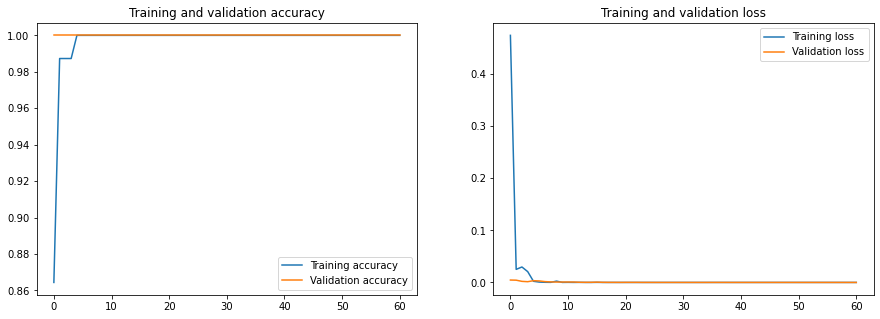

In [10]:
plot_accuracy_and_loss(history)

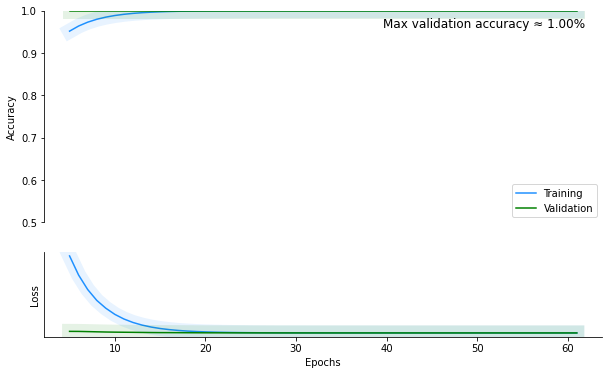

In [11]:
plot_history(history,xkcd=False)

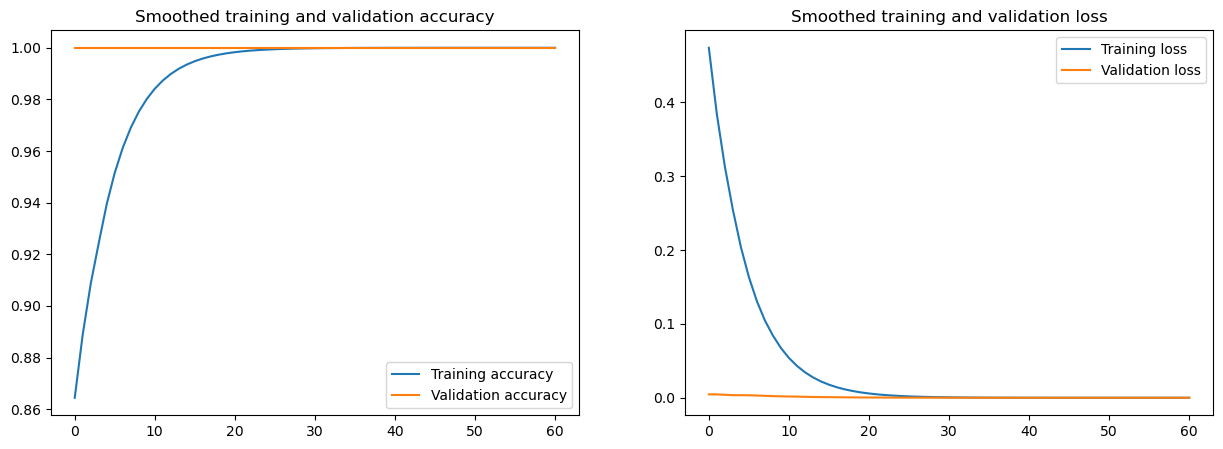

In [12]:
plot_smoothed_acc_and_loss(history, 0.8)

# 3 breeds

## Data preparation

In [13]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 412 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 89 images belonging to 3 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog']


## Model

In [14]:
conv_base = ResNet50V2(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [15]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [16]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 7 * 7 * 2048))
validation_features = np.reshape(validation_features, (-1, 7 * 7 * 2048))
test_features = np.reshape(test_features, (-1, 7 * 7 * 2048))

In [17]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_Resnet50v2_3_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_Resnet50v2_3_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 412 samples, validate on 88 samples
Epoch 1/1000
 - 1s - loss: 0.7160 - acc: 0.8131 - val_loss: 0.0513 - val_acc: 0.9659

Epoch 00001: val_loss improved from inf to 0.05127, saving model to tl_freeze_conv_base_Resnet50v2_3_breeds
Epoch 2/1000
 - 1s - loss: 0.0511 - acc: 0.9854 - val_loss: 0.0235 - val_acc: 0.9886

Epoch 00002: val_loss improved from 0.05127 to 0.02351, saving model to tl_freeze_conv_base_Resnet50v2_3_breeds
Epoch 3/1000
 - 1s - loss: 0.0444 - acc: 0.9806 - val_loss: 0.0110 - val_acc: 1.0000

Epoch 00003: val_loss improved from 0.02351 to 0.01095, saving model to tl_freeze_conv_base_Resnet50v2_3_breeds
Epoch 4/1000
 - 1s - loss: 0.0066 - acc: 1.0000 - val_loss: 0.0239 - val_acc: 0.9886

Epoch 00004: val_loss did not improve from 0.01095
Epoch 5/1000
 - 1s - loss: 0.0014 - acc: 1.0000 - val_loss: 0.0129 - val_acc: 0.9886

Epoch 00005: val_loss did not improve from 0.01095
Epoch 6/1000
 - 1s - loss: 0.0040 - acc: 1.0000 - val_loss: 0.0033 - val_acc: 1.0000

Epoch

## Results

In [18]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

89/89 [==============================] - 0s 1ms/step


[0.0002746310306269007, 1.0]

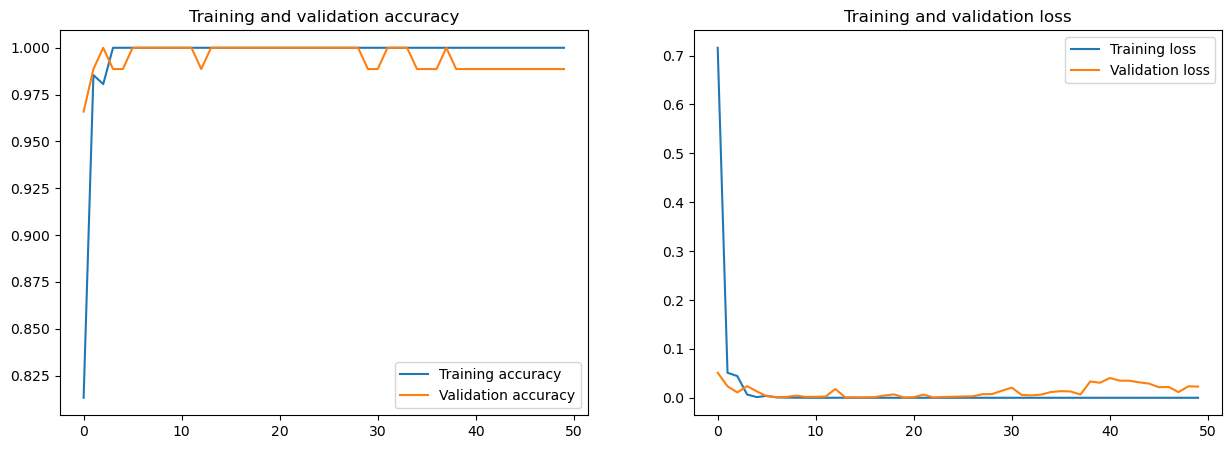

In [19]:
plot_accuracy_and_loss(history)

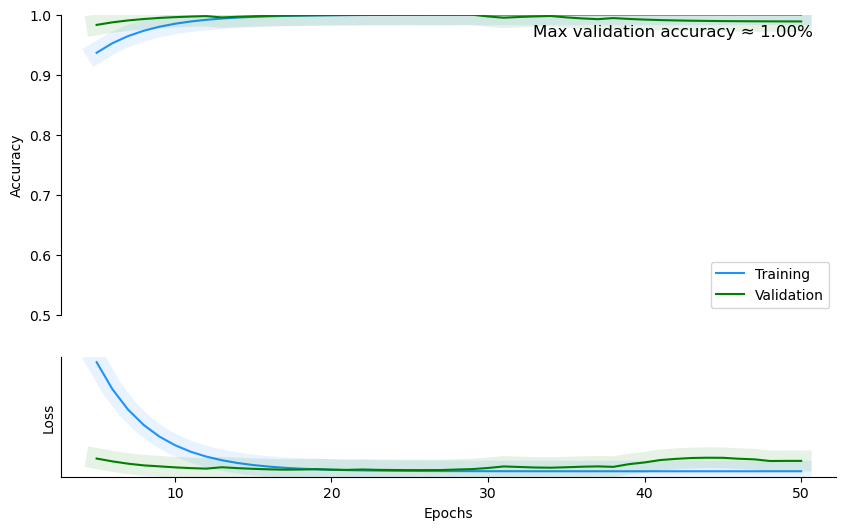

In [20]:
plot_history(history,xkcd=False)

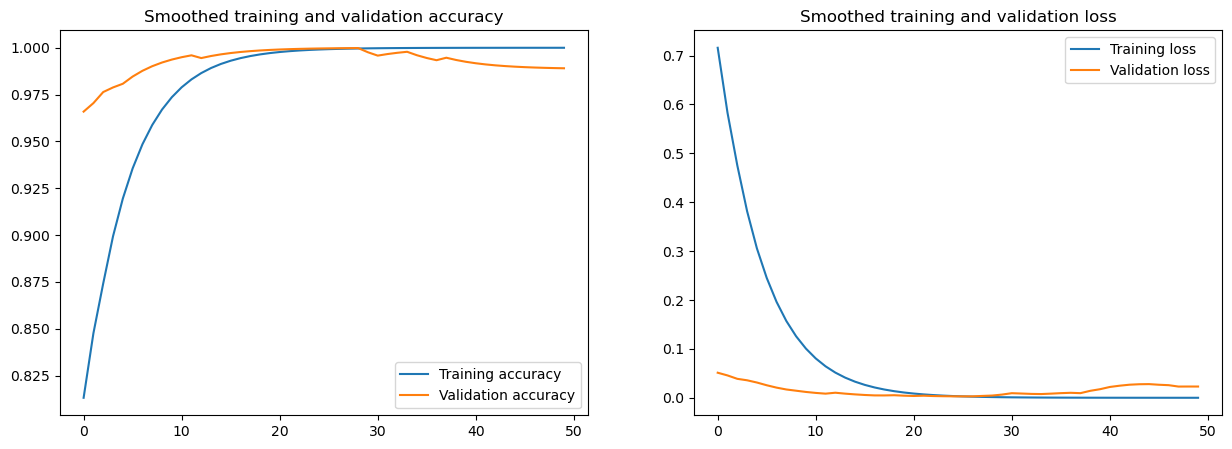

In [21]:
plot_smoothed_acc_and_loss(history, 0.8)

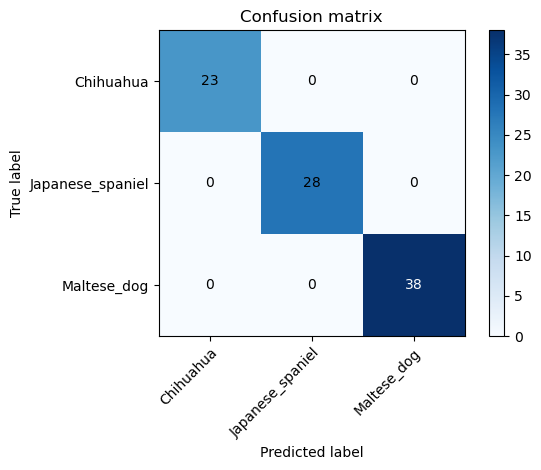

In [22]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 5 breeds

## Data preparation

In [23]:
classes = ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 666 images belonging to 5 classes.
Found 143 images belonging to 5 classes.
Found 143 images belonging to 5 classes.

Stored classes labels in classes_labels:  ['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih']


## Model

In [24]:
conv_base = ResNet50V2(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [25]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [26]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 7 * 7 * 2048))
validation_features = np.reshape(validation_features, (-1, 7 * 7 * 2048))
test_features = np.reshape(test_features, (-1, 7 * 7 * 2048))

In [27]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_Resnet50v2_5_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_Resnet50v2_5_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 666 samples, validate on 143 samples
Epoch 1/1000
 - 2s - loss: 2.1544 - acc: 0.5556 - val_loss: 0.5404 - val_acc: 0.8252

Epoch 00001: val_loss improved from inf to 0.54043, saving model to tl_freeze_conv_base_Resnet50v2_5_breeds
Epoch 2/1000
 - 1s - loss: 0.5860 - acc: 0.8438 - val_loss: 0.5006 - val_acc: 0.8392

Epoch 00002: val_loss improved from 0.54043 to 0.50058, saving model to tl_freeze_conv_base_Resnet50v2_5_breeds
Epoch 3/1000
 - 1s - loss: 0.2391 - acc: 0.9264 - val_loss: 0.5054 - val_acc: 0.8601

Epoch 00003: val_loss did not improve from 0.50058
Epoch 4/1000
 - 1s - loss: 0.1254 - acc: 0.9640 - val_loss: 0.4985 - val_acc: 0.8671

Epoch 00004: val_loss improved from 0.50058 to 0.49852, saving model to tl_freeze_conv_base_Resnet50v2_5_breeds
Epoch 5/1000
 - 1s - loss: 0.0822 - acc: 0.9655 - val_loss: 0.4803 - val_acc: 0.8811

Epoch 00005: val_loss improved from 0.49852 to 0.48034, saving model to tl_freeze_conv_base_Resnet50v2_5_breeds
Epoch 6/1000
 - 1s - loss: 0.

## Results

In [28]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

143/143 [==============================] - 0s 897us/step


[0.4264260526303645, 0.9230769276618958]

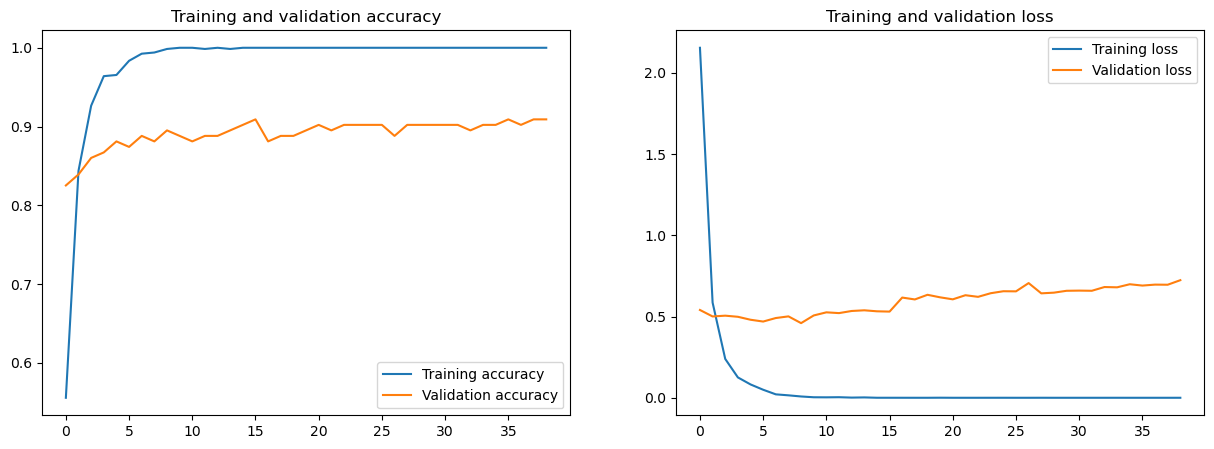

In [29]:
plot_accuracy_and_loss(history)

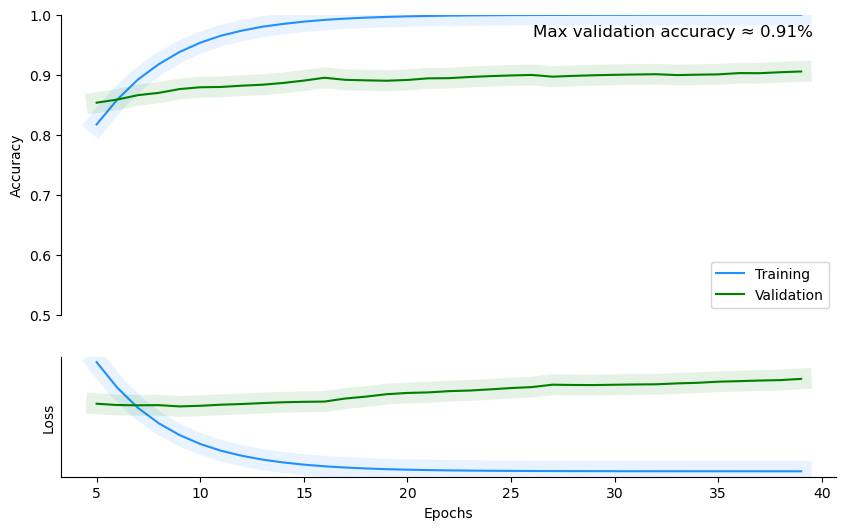

In [30]:
plot_history(history,xkcd=False)

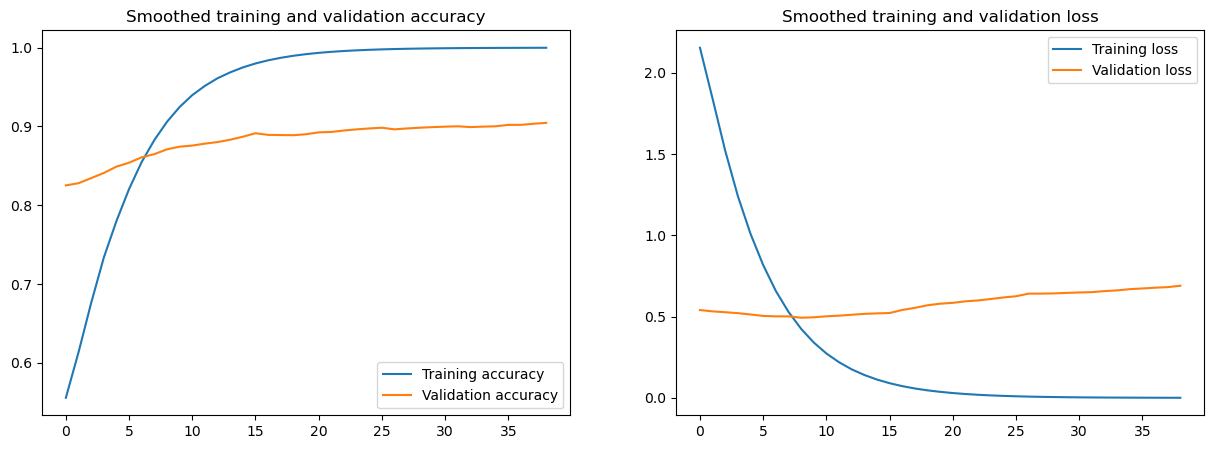

In [31]:
plot_smoothed_acc_and_loss(history, 0.8)

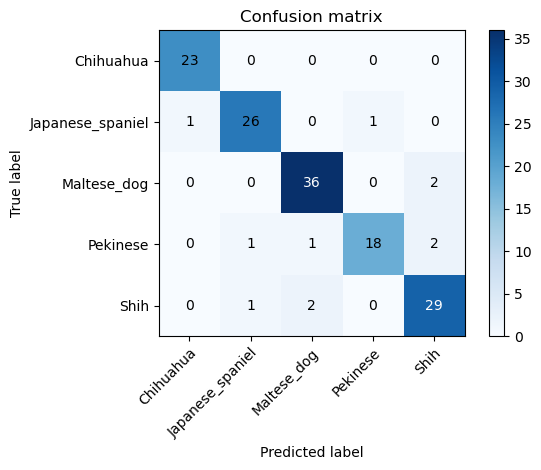

In [32]:
plot_confusion_matrix(y_true=np.argmax(test_labels, axis=-1), 
                      y_pred=model.predict_classes(test_features), 
                      classes=classes_labels)
plt.show()

# 60 breeds

## Data preparation

In [5]:
classes = os.listdir(PATH + train_dir)[:60]

train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=classes)

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 7072 images belonging to 60 classes.
Found 1527 images belonging to 60 classes.
Found 1512 images belonging to 60 classes.

Stored classes labels in classes_labels:  ['affenpinscher', 'Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'basenji', 'basset', 'beagle', 'Bedlington_terrier', 'Bernese_mountain_dog', 'black', 'Blenheim_spaniel', 'bloodhound', 'bluetick', 'Border_collie', 'Border_terrier', 'borzoi', 'Boston_bull', 'Bouvier_des_Flandres', 'boxer', 'Brabancon_griffon', 'briard', 'Brittany_spaniel', 'bull_mastiff', 'cairn', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly', 'Dandie_Dinmont', 'dhole', 'dingo', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'flat', 'French_bulldog', 'German_shepherd', 'German_short', 'giant_schnauzer', 'golden_retriever', 'Gordon_setter', 'Greater_Swiss_Mountain_do

## Model

In [6]:
conv_base = ResNet50V2(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [7]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [8]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 7 * 7 * 2048))
validation_features = np.reshape(validation_features, (-1, 7 * 7 * 2048))
test_features = np.reshape(test_features, (-1, 7 * 7 * 2048))

In [37]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-4),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_Resnet50v2_60_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_Resnet50v2_60_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 7072 samples, validate on 1527 samples
Epoch 1/1000
 - 15s - loss: 2.7243 - acc: 0.4887 - val_loss: 1.1578 - val_acc: 0.7164

Epoch 00001: val_loss improved from inf to 1.15783, saving model to tl_freeze_conv_base_Resnet50v2_60_breeds
Epoch 2/1000
 - 14s - loss: 1.2159 - acc: 0.7640 - val_loss: 1.3221 - val_acc: 0.7433

Epoch 00002: val_loss did not improve from 1.15783
Epoch 3/1000
 - 14s - loss: 0.7860 - acc: 0.8457 - val_loss: 1.4819 - val_acc: 0.7701

Epoch 00003: val_loss did not improve from 1.15783
Epoch 4/1000
 - 14s - loss: 0.5424 - acc: 0.8947 - val_loss: 1.4745 - val_acc: 0.7787

Epoch 00004: val_loss did not improve from 1.15783
Epoch 5/1000
 - 14s - loss: 0.4072 - acc: 0.9204 - val_loss: 1.7099 - val_acc: 0.7911

Epoch 00005: val_loss did not improve from 1.15783
Epoch 6/1000
 - 14s - loss: 0.3236 - acc: 0.9361 - val_loss: 1.6592 - val_acc: 0.7832

Epoch 00006: val_loss did not improve from 1.15783
Epoch 7/1000
 - 14s - loss: 0.2396 - acc: 0.9535 - val_loss: 2.018

## Results

In [38]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

1512/1512 [==============================] - 1s 912us/step


[1.187614996715513, 0.7208994626998901]

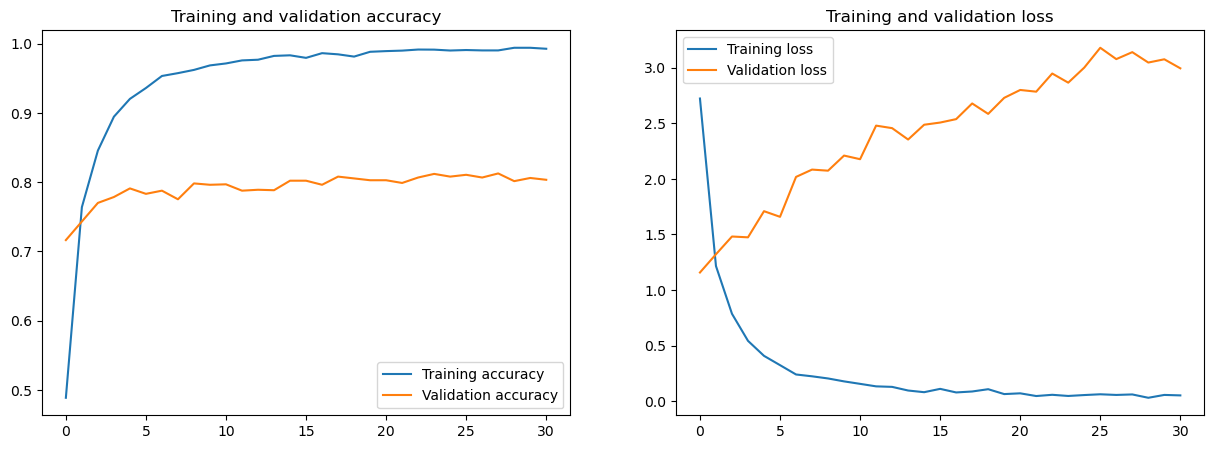

In [39]:
plot_accuracy_and_loss(history)

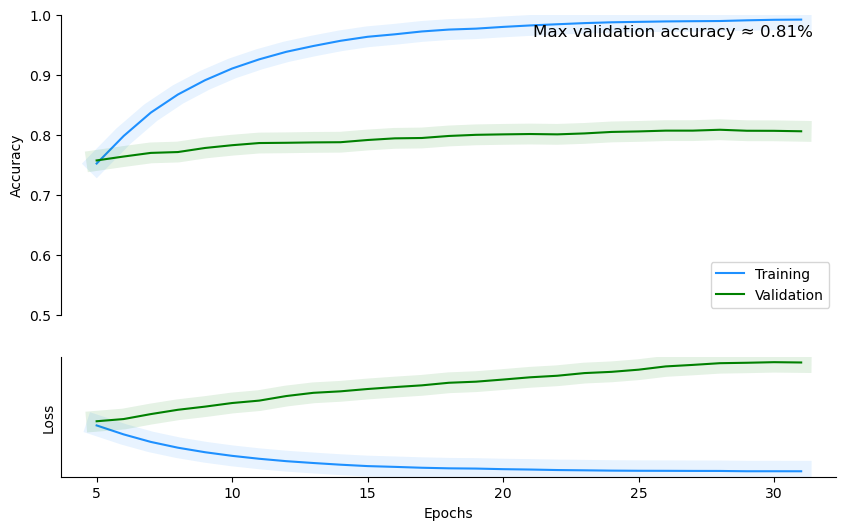

In [40]:
plot_history(history,xkcd=False)

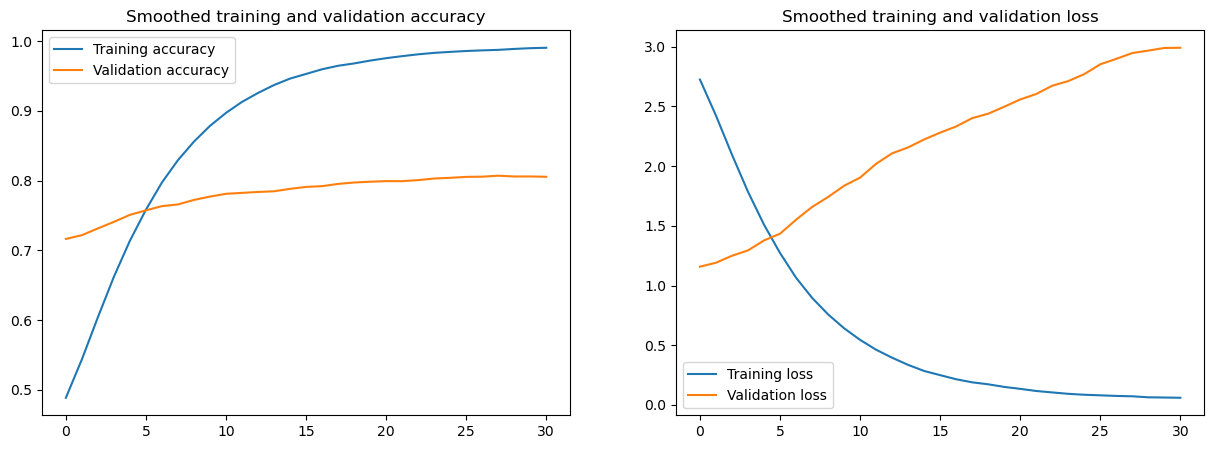

In [41]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 3600x3600 with 0 Axes>

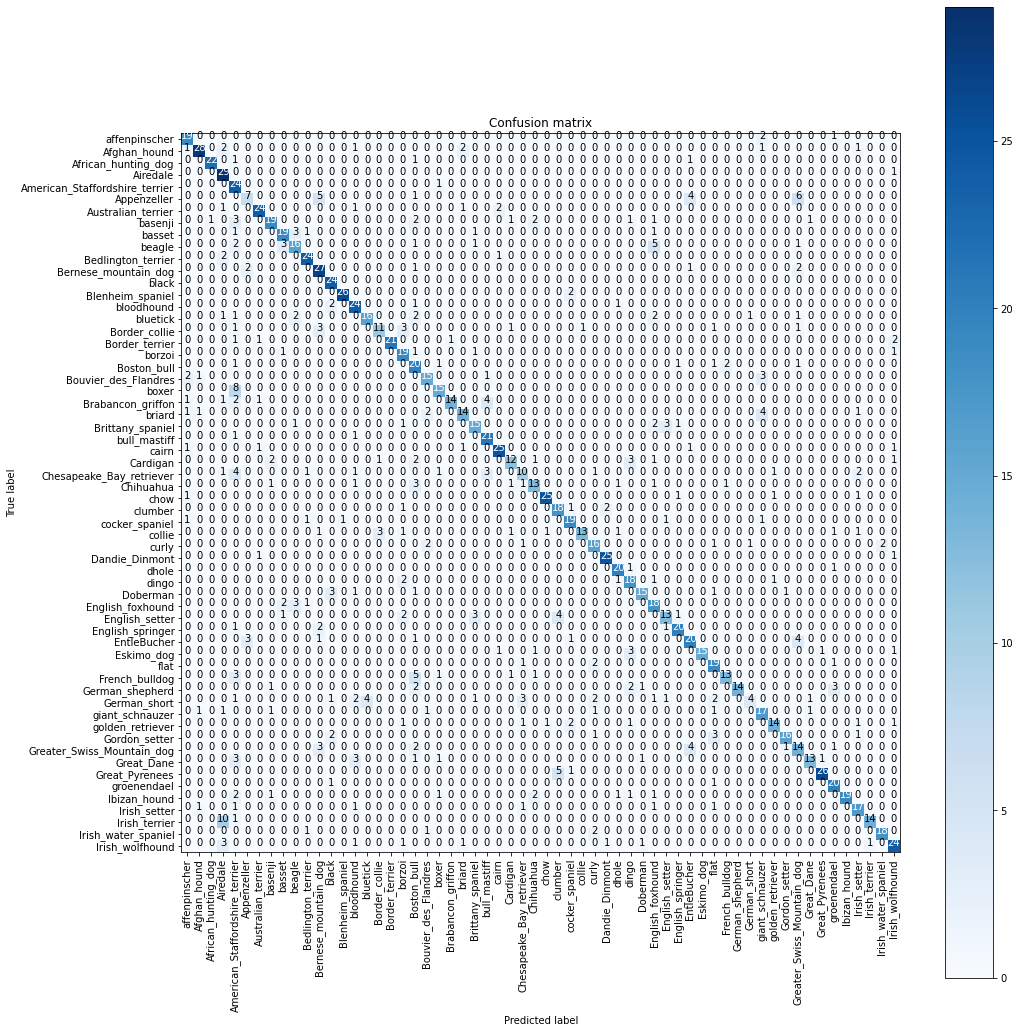

In [12]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()

# 120 breeds

## Data preparation

In [42]:
train_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    PATH + train_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    PATH + validation_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
    PATH + test_dir,
    target_size=STD_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical')

# Get class labels
inv_class_indices = {v: k for k, v in train_generator.class_indices.items()}
classes_labels = []
for i in range(len(inv_class_indices)):
    classes_labels.append(inv_class_indices[i])
print('\nStored classes labels in classes_labels: ', classes_labels)

Found 14397 images belonging to 120 classes.
Found 3099 images belonging to 120 classes.
Found 3084 images belonging to 120 classes.

Stored classes labels in classes_labels:  ['Afghan_hound', 'African_hunting_dog', 'Airedale', 'American_Staffordshire_terrier', 'Appenzeller', 'Australian_terrier', 'Bedlington_terrier', 'Bernese_mountain_dog', 'Blenheim_spaniel', 'Border_collie', 'Border_terrier', 'Boston_bull', 'Bouvier_des_Flandres', 'Brabancon_griffon', 'Brittany_spaniel', 'Cardigan', 'Chesapeake_Bay_retriever', 'Chihuahua', 'Dandie_Dinmont', 'Doberman', 'English_foxhound', 'English_setter', 'English_springer', 'EntleBucher', 'Eskimo_dog', 'French_bulldog', 'German_shepherd', 'German_short', 'Gordon_setter', 'Great_Dane', 'Great_Pyrenees', 'Greater_Swiss_Mountain_dog', 'Ibizan_hound', 'Irish_setter', 'Irish_terrier', 'Irish_water_spaniel', 'Irish_wolfhound', 'Italian_greyhound', 'Japanese_spaniel', 'Kerry_blue_terrier', 'Labrador_retriever', 'Lakeland_terrier', 'Leonberg', 'Lhasa', '

# Model

In [44]:
conv_base = ResNet50V2(weights='imagenet', 
                  include_top = False,
                  input_shape = (STD_SIZE[0], STD_SIZE[1], 3))

In [45]:
conv_base.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_________________________________________________________________________________________

In [57]:
train_features, train_labels = extract_features(
    generator=train_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

validation_features, validation_labels = extract_features(
    generator=validation_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

test_features, test_labels = extract_features(
    generator=test_generator, 
    feature_size=(7, 7, 2048), 
    batch_size=BATCH_SIZE, 
    n_classes=len(classes_labels),
    model=conv_base)

train_features = np.reshape(train_features, (-1, 7 * 7 * 2048))
validation_features = np.reshape(validation_features, (-1, 7 * 7 * 2048))
test_features = np.reshape(test_features, (-1, 7 * 7 * 2048))

In [58]:
model = Sequential()
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(classes_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit(
    train_features, train_labels,
    epochs=1000, batch_size=BATCH_SIZE, verbose=2,
    validation_data=(validation_features, validation_labels),
    callbacks=[History(),
               ModelCheckpoint(PATH + 'tl_freeze_conv_base_120_breeds', monitor='val_loss', save_best_only=True, verbose=1),
               EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
              ])

with open(PATH + 'tl_freeze_conv_base_120_breeds_history', 'wb') as f:
    pickle.dump(history.history, f)

Train on 14397 samples, validate on 3099 samples
Epoch 1/1000
 - 66s - loss: 4.2872 - acc: 0.1753 - val_loss: 1.9628 - val_acc: 0.5166

Epoch 00001: val_loss improved from inf to 1.96280, saving model to tl_freeze_conv_base_120_breeds
Epoch 2/1000
 - 59s - loss: 1.9778 - acc: 0.5143 - val_loss: 1.4161 - val_acc: 0.6254

Epoch 00002: val_loss improved from 1.96280 to 1.41612, saving model to tl_freeze_conv_base_120_breeds
Epoch 3/1000
 - 64s - loss: 1.2305 - acc: 0.6727 - val_loss: 1.3009 - val_acc: 0.6554

Epoch 00003: val_loss improved from 1.41612 to 1.30092, saving model to tl_freeze_conv_base_120_breeds
Epoch 4/1000
 - 45s - loss: 0.7958 - acc: 0.7772 - val_loss: 1.2710 - val_acc: 0.6657

Epoch 00004: val_loss improved from 1.30092 to 1.27100, saving model to tl_freeze_conv_base_120_breeds
Epoch 5/1000
 - 67s - loss: 0.5540 - acc: 0.8400 - val_loss: 1.2757 - val_acc: 0.6741

Epoch 00005: val_loss did not improve from 1.27100
Epoch 6/1000
 - 82s - loss: 0.3798 - acc: 0.8866 - val_lo

## Results

In [59]:
model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE)

3084/3084 [==============================] - 21s 7ms/step


[1.3372426353849172, 0.6559662818908691]

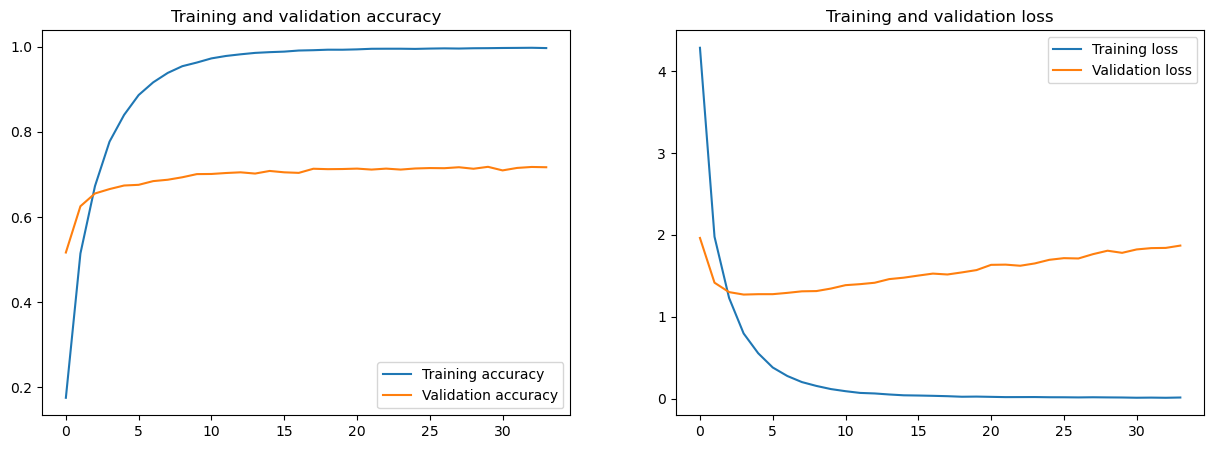

In [60]:
plot_accuracy_and_loss(history)

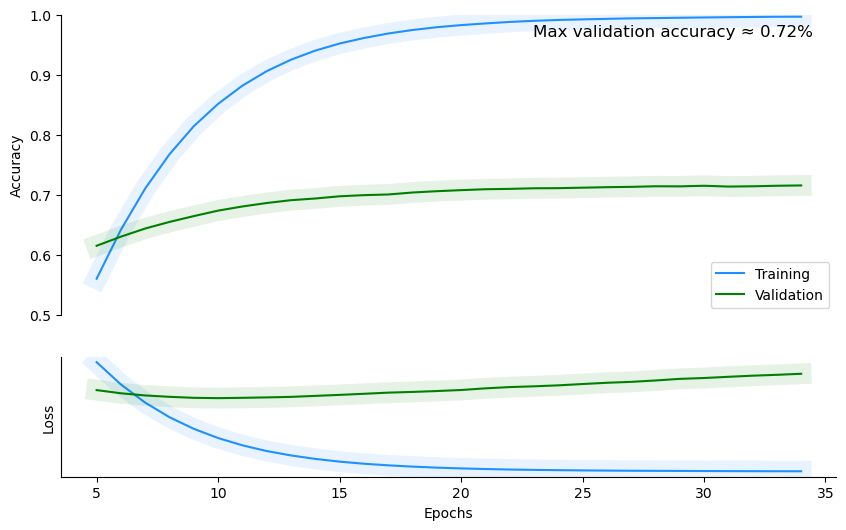

In [61]:
plot_history(history,xkcd=False)

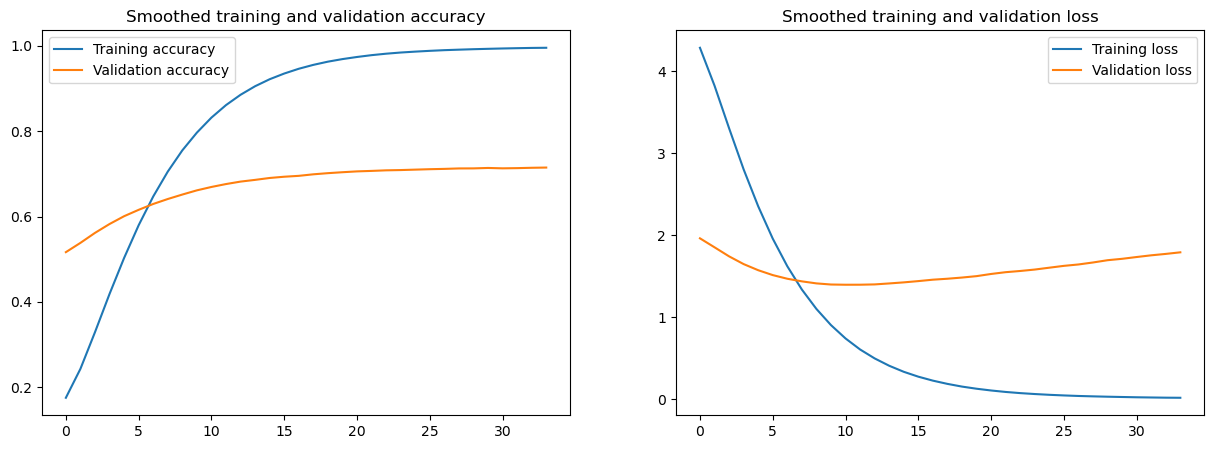

In [62]:
plot_smoothed_acc_and_loss(history, 0.8)

<Figure size 5000x5000 with 0 Axes>

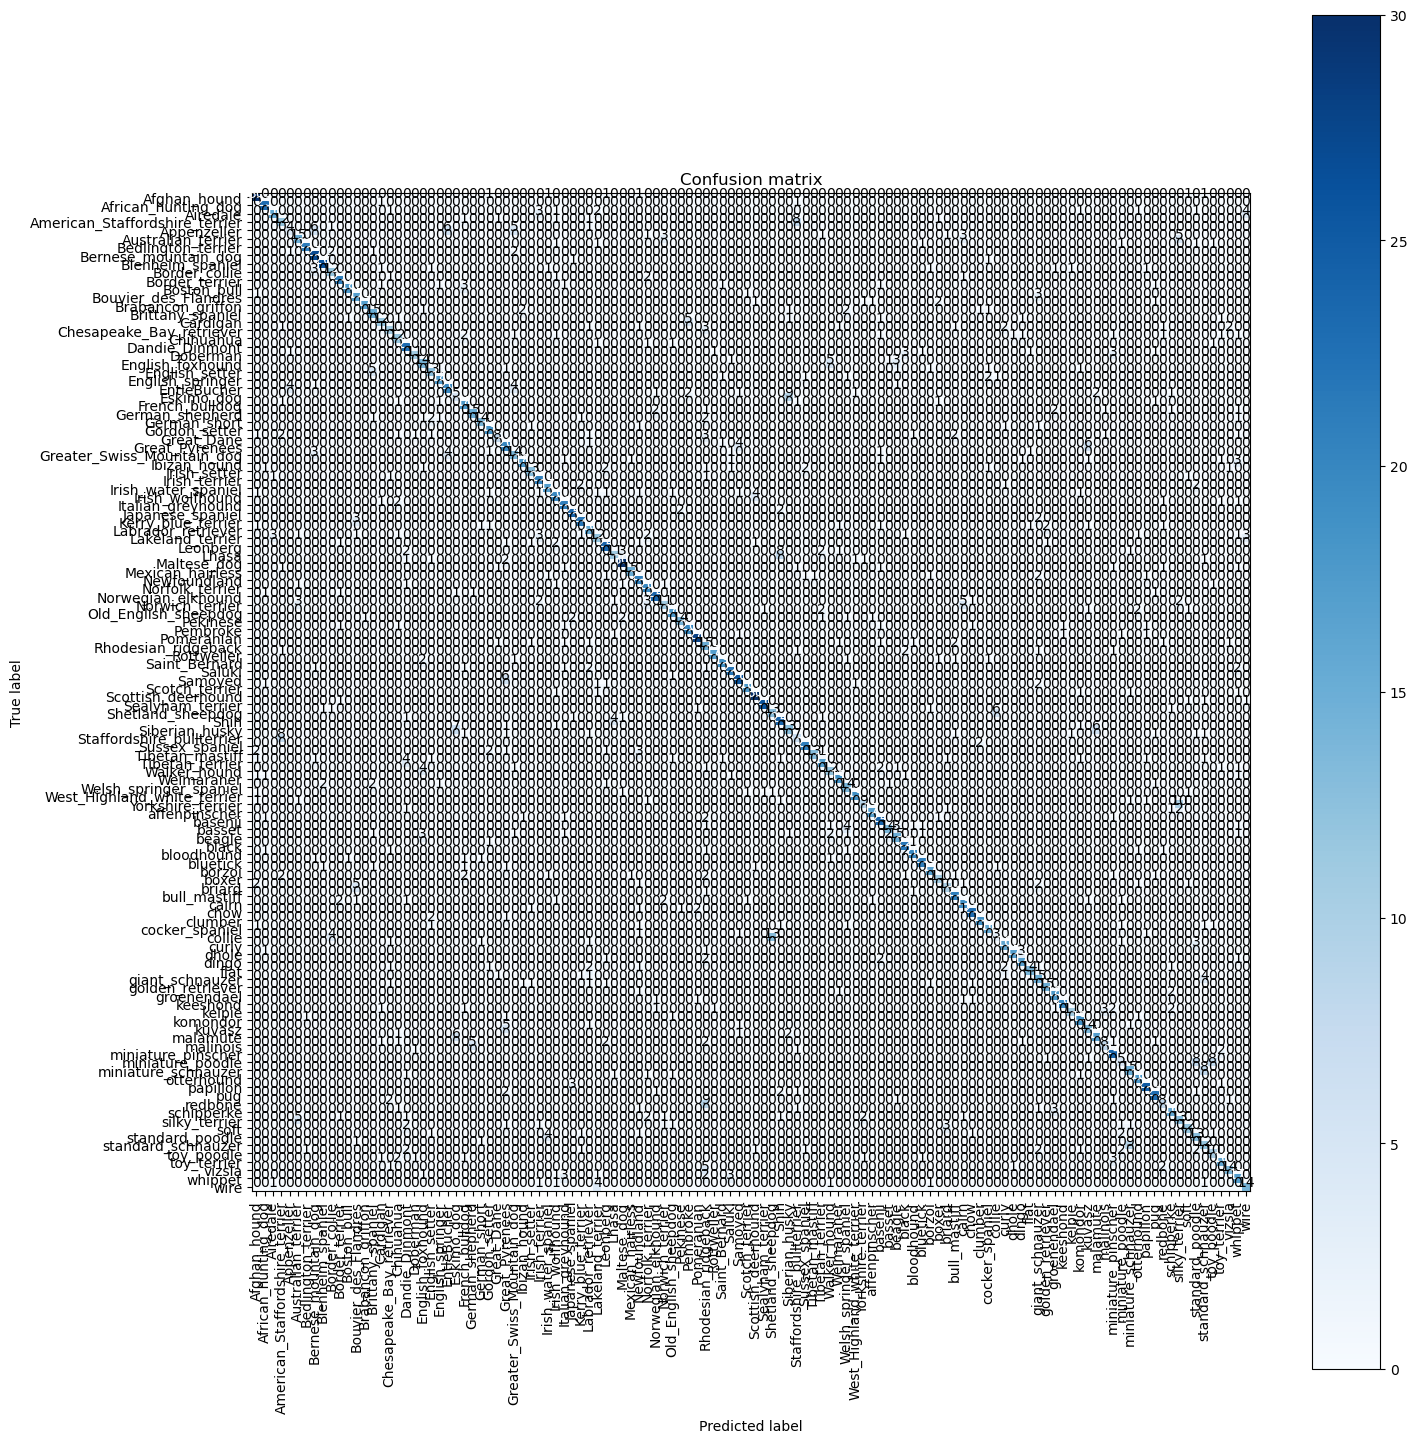

In [63]:
y_true=np.argmax(test_labels, axis=-1)
y_pred=model.predict_classes(test_features)
confusion_mtx = confusion_matrix(y_true, y_pred) 
plot_confusion_matrix(confusion_mtx, 
                      classes=classes_labels)
plt.show()